In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls

'Banana Disease Recognition Dataset'/   models_resnet18/   models_vgg16/   ThProject.ipynb
 BananaLSD/                             models_resnet50/   models_vgg19/


In [ ]:
cd "/content/drive/MyDrive/Banana Leaf /Banana Leaf"

/content/drive/MyDrive/Banana Leaf /Banana Leaf


In [ ]:
ls

'Banana Disease Recognition Dataset'/   models_resnet18/   models_vgg16/   ThProject.ipynb
 BananaLSD/                             models_resnet50/   models_vgg19/


### Importing Libraries

In [ ]:
import torch, torchvision
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image
import pandas as pd
from collections import Counter

### Initializing Parameters

In [ ]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 32,
    "num_workers": 2,
    "epochs": 30,
}

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per Res
    ])

### Dataset Class

In [ ]:
class BananaLeafDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = []
    self.labels = []
    self.classes = ['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']
    self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
    # print("self.class_to_idx ", self.class_to_idx)
    self._load_images()

  def _load_images(self):
    for dir in self.root_dir:
      print(dir)
      for class_name in self.classes:
        class_dir = os.path.join(dir, class_name)
        image_files = glob.glob(os.path.join(class_dir, '*.jpeg')) + glob.glob(os.path.join(class_dir, '*.jpg')) + glob.glob(os.path.join(class_dir, '*.png'))
        for images in image_files:
          # print("images ", images)
          # print("class_name ", class_name)
          self.image_paths.append(images)
          self.labels.append(self.class_to_idx[class_name])

  def __len__(self):
    return len(self.image_paths)

  def get_class_distribution(self):
    return Counter(self.labels)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    image = Image.open(img_path).convert('RGB')
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label


In [ ]:
data_dir = ['BananaLSD/AugmentedSet', 'BananaLSD/OriginalSet']
# print(data_dir)
dataset = BananaLeafDataset(root_dir=data_dir, transform=transform)

BananaLSD/AugmentedSet
BananaLSD/OriginalSet


In [ ]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
dataiter = iter(dataloader)
images, labels = next(dataiter)

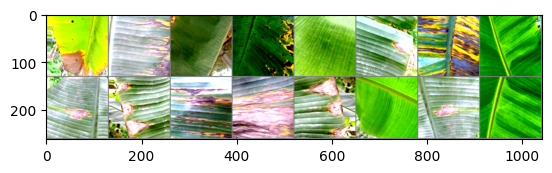

cordana sigatoka healthy pestalotiopsis healthy cordana sigatoka healthy cordana cordana sigatoka sigatoka cordana healthy cordana healthy


In [ ]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{dataset.classes[labels[j]]}' for j in range(16)))

In [ ]:
print("length of dataset: ", len(dataset))

length of dataset:  2537


In [ ]:
class_distribution = dataset.get_class_distribution()
class_names = [dataset.classes[i] for i in class_distribution.keys()]
class_counts = list(class_distribution.values())

In [ ]:
print("class_distribution: ", class_distribution)
print("class_names: ", class_names)
print("class_counts: ", class_counts)

class_distribution:  Counter({3: 873, 2: 573, 0: 562, 1: 529})
class_names:  ['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']
class_counts:  [562, 529, 573, 873]


In [ ]:
df = pd.DataFrame({
    'Class': class_names,
    'Count': class_counts
})

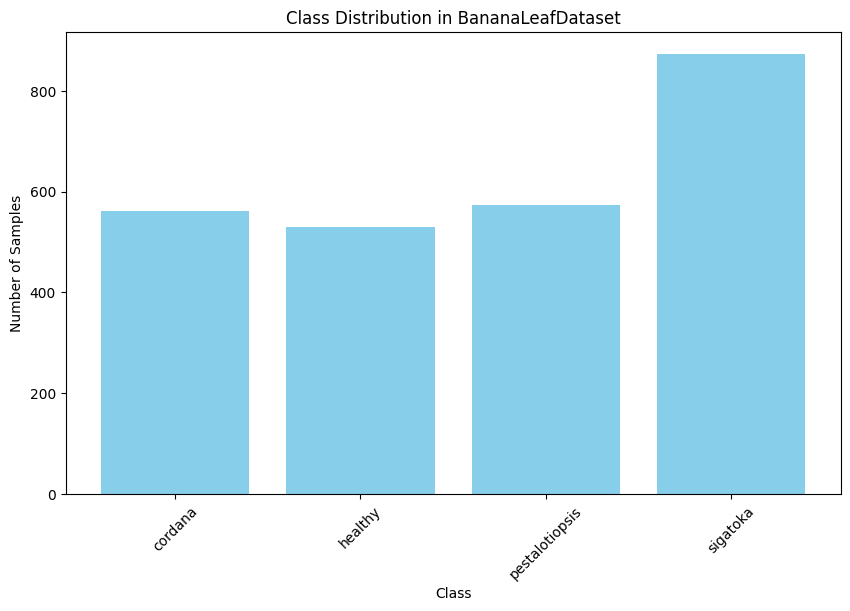

In [ ]:
# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(df['Class'], df['Count'], color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in BananaLeafDataset')
plt.xticks(rotation=45)
plt.show()

In [ ]:
class VGG16Model(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super(VGG16Model, self).__init__()
        self.model = models.vgg16(pretrained=pretrained)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

print(VGG16Model())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 165MB/s]


VGG16Model(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [ ]:
class VGG19Model(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super(VGG19Model, self).__init__()
        self.model = models.vgg19(pretrained=pretrained)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

print(VGG19Model())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 173MB/s]


VGG19Model(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [ ]:
class ResNet18Model(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super(ResNet18Model, self).__init__()
        self.model = models.resnet18(pretrained=pretrained)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    def forward(self, x):
        return self.model(x)

resnet18 = ResNet18Model()
print(resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.7MB/s]

ResNet18Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    def forward(self, x):
        return self.model(x)

resnet50 = ResNet50Model()
print(resnet50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=params['num_workers'])
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'])
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'])

In [ ]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Train Epoch {epoch}', leave=False)
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(params['device']), target.to(params['device'])
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        progress_bar.set_postfix(loss=running_loss/(batch_idx+1), accuracy=100.*correct/total)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    print(f'Train Epoch: {epoch} \tLoss: {epoch_loss:.6f} \tAccuracy: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(val_loader, desc='Validation', leave=False)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(params['device']), target.to(params['device'])
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            progress_bar.set_postfix(loss=val_loss/(batch_idx+1), accuracy=100.*correct/total)

    val_loss /= len(val_loader.dataset)
    val_acc = 100. * correct / total
    print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{total} ({val_acc:.2f}%)\n')
    return val_loss, val_acc

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, params):
    # Initialize optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss()

    # Logs to keep track of loss and accuracy
    train_log = {'loss': [], 'accuracy': []}
    val_log = {'loss': [], 'accuracy': []}

    # Training loop with model saving
    best_val_acc = 0
    for epoch in range(1, params['epochs'] + 1):
        train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, params)
        val_loss, val_acc = validate(val_loader, model, criterion, epoch, params)

        train_log['loss'].append(train_loss)
        train_log['accuracy'].append(train_acc)
        val_log['loss'].append(val_loss)
        val_log['accuracy'].append(val_acc)

        # Save the model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"./models_{params['model']}/weights/weight_model_epoch_{epoch}_{params['model']}.pth")

    # # Test the best model
    # print(f"Testing the best {params['model']} model...")
    # model.load_state_dict(torch.load(f"best_{params['model']}_model_epoch_{epoch}.pth"))
    # test_loss, test_acc = test(test_loader, model, criterion, params)

    # Plot the training and validation accuracy and loss
    epochs_range = range(1, params['epochs'] + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_log['loss'], label='Training loss')
    plt.plot(epochs_range, val_log['loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Loss for {params["model"]}')
    plt.savefig(f"./models_{params['model']}/figures/loss_plot.png")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_log['accuracy'], label='Training accuracy')
    plt.plot(epochs_range, val_log['accuracy'], label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Training and Validation Accuracy for {params["model"]}')
    plt.savefig(f"./models_{params['model']}/figures/accuracy_plot.png")

    plt.show()


In [ ]:
if params['model'] == 'resnet18':
    model = ResNet18Model(num_classes=4, pretrained=True).to(params['device'])
elif params['model'] == 'resnet50':
    model = ResNet50Model(num_classes=4, pretrained=True).to(params['device'])
elif params['model'] == 'vgg16':
    model = VGG16Model(num_classes=4, pretrained=True).to(params['device'])
elif params['model'] == 'vgg19':
    model = VGG19Model(num_classes=4, pretrained=True).to(params['device'])
else:
    raise ValueError("Unsupported model type")

Train Epoch 1:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 1:  12%|█▏        | 13/111 [00:01<00:12,  7.85it/s, accuracy=59.1, loss=0.951]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 1 	Loss: 0.795813 	Accuracy: 67.72%


Validation set: Average loss: 0.0294, Accuracy: 298/380 (78.42%)



Train Epoch 2:   2%|▏         | 2/111 [00:00<00:24,  4.38it/s, accuracy=75, loss=0.518]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 2:  21%|██        | 23/111 [00:03<00:10,  8.04it/s, accuracy=83.7, loss=0.381]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 2 	Loss: 0.542577 	Accuracy: 81.13%


Validation set: Average loss: 0.0274, Accuracy: 339/380 (89.21%)



Train Epoch 3:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 3:   7%|▋         | 8/111 [00:01<00:14,  6.99it/s, accuracy=85.9, loss=0.333]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 3 	Loss: 0.316754 	Accuracy: 90.31%


Validation set: Average loss: 0.0520, Accuracy: 328/380 (86.32%)



Train Epoch 4:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 4:   6%|▋         | 7/111 [00:01<00:14,  7.02it/s, accuracy=92.9, loss=0.276]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 4 	Loss: 0.409835 	Accuracy: 87.94%


Validation set: Average loss: 0.0174, Accuracy: 356/380 (93.68%)



Train Epoch 5:   3%|▎         | 3/111 [00:00<00:24,  4.35it/s, accuracy=97.9, loss=0.0492]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 5:  17%|█▋        | 19/111 [00:03<00:13,  6.82it/s, accuracy=89.1, loss=0.41]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 5 	Loss: 0.204490 	Accuracy: 93.52%


Validation set: Average loss: 0.0049, Accuracy: 373/380 (98.16%)



Train Epoch 6:  10%|▉         | 11/111 [00:01<00:13,  7.38it/s, accuracy=98.9, loss=0.0309]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 6:  60%|██████    | 67/111 [00:08<00:05,  7.38it/s, accuracy=97.3, loss=0.115]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 6 	Loss: 0.150839 	Accuracy: 96.28%


Validation set: Average loss: 0.0290, Accuracy: 328/380 (86.32%)



Train Epoch 7:  10%|▉         | 11/111 [00:01<00:12,  7.97it/s, accuracy=92.6, loss=0.359]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 7:  18%|█▊        | 20/111 [00:02<00:11,  8.06it/s, accuracy=94.7, loss=0.269]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 7 	Loss: 0.160598 	Accuracy: 96.39%


Validation set: Average loss: 0.0011, Accuracy: 378/380 (99.47%)



Train Epoch 8:   7%|▋         | 8/111 [00:01<00:15,  6.52it/s, accuracy=98.4, loss=0.0373]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 8:  23%|██▎       | 25/111 [00:03<00:11,  7.30it/s, accuracy=98.8, loss=0.0292]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 8 	Loss: 0.095928 	Accuracy: 97.69%


Validation set: Average loss: 0.0016, Accuracy: 378/380 (99.47%)



Train Epoch 9:  18%|█▊        | 20/111 [00:02<00:12,  7.21it/s, accuracy=99.4, loss=0.0154]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 9:  67%|██████▋   | 74/111 [00:10<00:04,  8.06it/s, accuracy=99.5, loss=0.0162]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 9 	Loss: 0.019162 	Accuracy: 99.32%


Validation set: Average loss: 0.0047, Accuracy: 375/380 (98.68%)



Train Epoch 10:   8%|▊         | 9/111 [00:01<00:13,  7.38it/s, accuracy=97.9, loss=0.0545]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 10:  63%|██████▎   | 70/111 [00:09<00:05,  8.03it/s, accuracy=86.6, loss=0.551]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 10 	Loss: 0.698262 	Accuracy: 75.44%


Validation set: Average loss: 0.0882, Accuracy: 126/380 (33.16%)



Train Epoch 11:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 11:  33%|███▎      | 37/111 [00:05<00:10,  6.94it/s, accuracy=48.1, loss=1.1]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 11 	Loss: 0.914254 	Accuracy: 58.25%


Validation set: Average loss: 0.0395, Accuracy: 283/380 (74.47%)



Train Epoch 12:  14%|█▍        | 16/111 [00:02<00:13,  6.92it/s, accuracy=66.4, loss=0.748]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 12:  30%|██▉       | 33/111 [00:04<00:10,  7.15it/s, accuracy=65.3, loss=0.763]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 12:  31%|███       | 34/111 [00:04<00:11,  6.84it/s, accuracy=65.3, loss=0.763]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 12 	Loss: 0.662534 	Accuracy: 70.42%


Validation set: Average loss: 0.0349, Accuracy: 289/380 (76.05%)



Train Epoch 13:  26%|██▌       | 29/111 [00:04<00:11,  7.29it/s, accuracy=78.7, loss=0.52]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 13:  49%|████▊     | 54/111 [00:07<00:07,  7.99it/s, accuracy=78.5, loss=0.509]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 13 	Loss: 0.547686 	Accuracy: 78.08%


Validation set: Average loss: 0.0276, Accuracy: 318/380 (83.68%)



Train Epoch 14:   7%|▋         | 8/111 [00:01<00:16,  6.22it/s, accuracy=78.1, loss=0.536]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 14:  20%|█▉        | 22/111 [00:03<00:11,  7.42it/s, accuracy=79.5, loss=0.493]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 14 	Loss: 0.576617 	Accuracy: 79.10%


Validation set: Average loss: 0.0315, Accuracy: 317/380 (83.42%)



Train Epoch 15:   1%|          | 1/111 [00:00<00:42,  2.59it/s, accuracy=81.2, loss=0.418]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 15:   8%|▊         | 9/111 [00:01<00:15,  6.71it/s, accuracy=85.6, loss=0.451]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 15:   9%|▉         | 10/111 [00:01<00:14,  6.82it/s, accuracy=85.6, loss=0.451]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 15 	Loss: 0.443482 	Accuracy: 85.86%


Validation set: Average loss: 0.0295, Accuracy: 325/380 (85.53%)



Train Epoch 16:  10%|▉         | 11/111 [00:01<00:14,  6.79it/s, accuracy=92, loss=0.312]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 16:  29%|██▉       | 32/111 [00:04<00:10,  7.35it/s, accuracy=93.4, loss=0.278]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 16 	Loss: 0.487755 	Accuracy: 85.07%


Validation set: Average loss: 0.0242, Accuracy: 318/380 (83.68%)



Train Epoch 17:  16%|█▌        | 18/111 [00:02<00:13,  6.93it/s, accuracy=81.9, loss=0.351]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 17:  21%|██        | 23/111 [00:03<00:11,  7.53it/s, accuracy=81.8, loss=0.348]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 17 	Loss: 0.269020 	Accuracy: 89.69%


Validation set: Average loss: 0.0222, Accuracy: 356/380 (93.68%)



Train Epoch 18:   7%|▋         | 8/111 [00:01<00:14,  7.33it/s, accuracy=96.1, loss=0.188]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 18:  15%|█▌        | 17/111 [00:02<00:11,  7.97it/s, accuracy=97.8, loss=0.103]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 18 	Loss: 0.555118 	Accuracy: 90.25%


Validation set: Average loss: 0.0241, Accuracy: 336/380 (88.42%)



Train Epoch 19:   7%|▋         | 8/111 [00:01<00:13,  7.63it/s, accuracy=82, loss=0.504]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 19 	Loss: 0.278418 	Accuracy: 91.04%


Validation set: Average loss: 0.0251, Accuracy: 344/380 (90.53%)



Train Epoch 20:  24%|██▍       | 27/111 [00:03<00:10,  7.97it/s, accuracy=97.5, loss=0.107]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 20:  36%|███▌      | 40/111 [00:05<00:08,  7.99it/s, accuracy=98, loss=0.0833]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 20 	Loss: 0.064767 	Accuracy: 98.31%


Validation set: Average loss: 0.0062, Accuracy: 368/380 (96.84%)



Train Epoch 21:   1%|          | 1/111 [00:00<00:35,  3.09it/s, accuracy=100, loss=0.0112]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 21:   4%|▎         | 4/111 [00:00<00:16,  6.39it/s, accuracy=95.3, loss=0.143]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 21 	Loss: 0.167285 	Accuracy: 96.28%


Validation set: Average loss: 0.0038, Accuracy: 371/380 (97.63%)



Train Epoch 22:   2%|▏         | 2/111 [00:00<00:24,  4.42it/s, accuracy=100, loss=0.0253]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 22:  44%|████▍     | 49/111 [00:06<00:07,  8.02it/s, accuracy=98.6, loss=0.0519]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 22 	Loss: 0.049074 	Accuracy: 98.70%


Validation set: Average loss: 0.0053, Accuracy: 371/380 (97.63%)



Train Epoch 23:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 23:   9%|▉         | 10/111 [00:01<00:12,  7.83it/s, accuracy=100, loss=0.0158]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 23 	Loss: 0.036208 	Accuracy: 99.44%


Validation set: Average loss: 0.0038, Accuracy: 376/380 (98.95%)



Train Epoch 24:   1%|          | 1/111 [00:00<00:30,  3.61it/s, accuracy=100, loss=0.0104]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 24:  41%|████      | 45/111 [00:05<00:08,  7.94it/s, accuracy=98.9, loss=0.0519]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 24 	Loss: 0.046346 	Accuracy: 99.04%


Validation set: Average loss: 0.0062, Accuracy: 369/380 (97.11%)



Train Epoch 25:   4%|▎         | 4/111 [00:00<00:16,  6.58it/s, accuracy=96.9, loss=0.153]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 25:  28%|██▊       | 31/111 [00:04<00:10,  7.71it/s, accuracy=99.2, loss=0.0345]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 25 	Loss: 0.084475 	Accuracy: 98.08%


Validation set: Average loss: 0.0020, Accuracy: 376/380 (98.95%)



Train Epoch 26:   6%|▋         | 7/111 [00:01<00:13,  7.51it/s, accuracy=99.1, loss=0.0287]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 26:  13%|█▎        | 14/111 [00:01<00:12,  7.92it/s, accuracy=99.1, loss=0.0346]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 26 	Loss: 0.099696 	Accuracy: 97.86%


Validation set: Average loss: 0.0019, Accuracy: 378/380 (99.47%)



Train Epoch 27:   3%|▎         | 3/111 [00:00<00:18,  5.82it/s, accuracy=100, loss=0.003]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 27:  11%|█         | 12/111 [00:01<00:12,  7.87it/s, accuracy=99.5, loss=0.0118]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 27 	Loss: 0.026678 	Accuracy: 99.21%


Validation set: Average loss: 0.0020, Accuracy: 377/380 (99.21%)



Train Epoch 28:   1%|          | 1/111 [00:00<00:32,  3.37it/s, accuracy=100, loss=5.18e-5]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 28:  32%|███▏      | 36/111 [00:04<00:09,  7.91it/s, accuracy=99.7, loss=0.0135]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 28 	Loss: 0.009360 	Accuracy: 99.77%


Validation set: Average loss: 0.0031, Accuracy: 376/380 (98.95%)



Train Epoch 29:   2%|▏         | 2/111 [00:00<00:21,  5.13it/s, accuracy=100, loss=0.00136]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 29:  40%|███▉      | 44/111 [00:05<00:09,  7.29it/s, accuracy=99.7, loss=0.0122]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 29 	Loss: 0.005251 	Accuracy: 99.89%


Validation set: Average loss: 0.0017, Accuracy: 378/380 (99.47%)



Train Epoch 30:   1%|          | 1/111 [00:00<00:35,  3.11it/s, accuracy=100, loss=1.34e-7]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 30:  38%|███▊      | 42/111 [00:05<00:09,  7.49it/s, accuracy=99.9, loss=0.00264]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 30 	Loss: 0.013858 	Accuracy: 99.66%


Validation set: Average loss: 0.0088, Accuracy: 375/380 (98.68%)



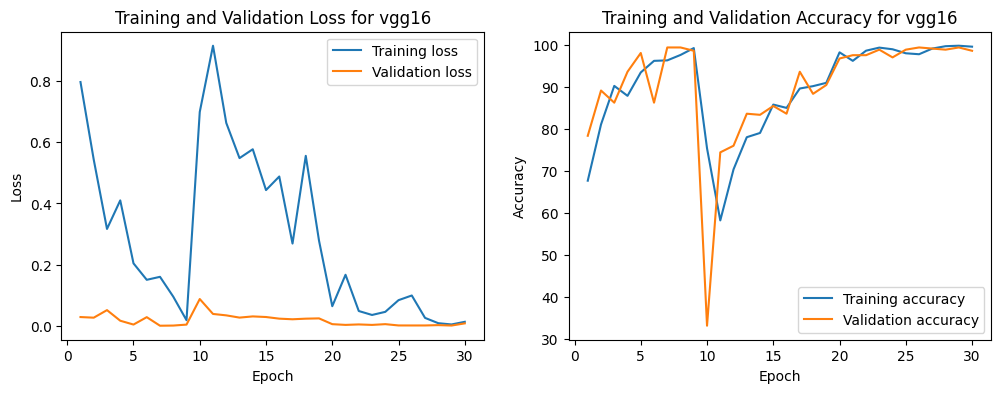

In [ ]:
# vgg16
train_and_evaluate(model, train_loader, val_loader, test_loader, params)

Train Epoch 1:   1%|          | 1/111 [00:00<00:50,  2.20it/s, accuracy=37.5, loss=1.38]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 1:   5%|▍         | 5/111 [00:01<00:19,  5.46it/s, accuracy=35, loss=1.44]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 1 	Loss: 0.709906 	Accuracy: 76.73%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0208, Accuracy: 319/380 (83.95%)



Train Epoch 2:   5%|▌         | 6/111 [00:01<00:18,  5.68it/s, accuracy=92.7, loss=0.188]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 2:   8%|▊         | 9/111 [00:01<00:15,  6.65it/s, accuracy=91, loss=0.322]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 2 	Loss: 0.473295 	Accuracy: 84.39%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0261, Accuracy: 308/380 (81.05%)



Train Epoch 3:   5%|▍         | 5/111 [00:00<00:16,  6.44it/s, accuracy=83.8, loss=0.389]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 3:  11%|█         | 12/111 [00:01<00:13,  7.14it/s, accuracy=87, loss=0.289]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 3 	Loss: 0.366868 	Accuracy: 88.39%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0349, Accuracy: 329/380 (86.58%)



Train Epoch 4:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 4:  29%|██▉       | 32/111 [00:04<00:10,  7.22it/s, accuracy=93.6, loss=0.255]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 4 	Loss: 0.202990 	Accuracy: 94.93%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0056, Accuracy: 372/380 (97.89%)



Train Epoch 5:   8%|▊         | 9/111 [00:01<00:15,  6.65it/s, accuracy=95.1, loss=0.14]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 5:  25%|██▌       | 28/111 [00:04<00:11,  7.25it/s, accuracy=98.4, loss=0.0544]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 5 	Loss: 0.200458 	Accuracy: 94.03%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0145, Accuracy: 350/380 (92.11%)



Train Epoch 6:  19%|█▉        | 21/111 [00:03<00:13,  6.81it/s, accuracy=94, loss=0.255]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 6:  22%|██▏       | 24/111 [00:03<00:12,  6.91it/s, accuracy=94.3, loss=0.242]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 6 	Loss: 0.166816 	Accuracy: 96.17%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0090, Accuracy: 368/380 (96.84%)



Train Epoch 7:  19%|█▉        | 21/111 [00:03<00:13,  6.60it/s, accuracy=98.8, loss=0.065]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 7:  25%|██▌       | 28/111 [00:04<00:12,  6.88it/s, accuracy=98.9, loss=0.0527]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 7 	Loss: 0.079165 	Accuracy: 98.25%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0232, Accuracy: 342/380 (90.00%)



Train Epoch 8:  19%|█▉        | 21/111 [00:03<00:12,  7.23it/s, accuracy=90.5, loss=0.357]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 8 	Loss: 0.384040 	Accuracy: 90.25%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0120, Accuracy: 358/380 (94.21%)



Train Epoch 9:  12%|█▏        | 13/111 [00:01<00:13,  7.27it/s, accuracy=93.8, loss=0.305]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 9:  77%|███████▋  | 86/111 [00:12<00:03,  6.33it/s, accuracy=96.2, loss=0.157]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 9 	Loss: 0.125184 	Accuracy: 96.96%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0054, Accuracy: 374/380 (98.42%)



Train Epoch 10:  49%|████▊     | 54/111 [00:08<00:08,  7.03it/s, accuracy=99.4, loss=0.111]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 10:  71%|███████   | 79/111 [00:12<00:04,  7.09it/s, accuracy=98, loss=0.112]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 10 	Loss: 0.113887 	Accuracy: 97.92%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0052, Accuracy: 373/380 (98.16%)



Train Epoch 11:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 11 	Loss: 0.167101 	Accuracy: 96.79%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0049, Accuracy: 374/380 (98.42%)



Train Epoch 12:   5%|▌         | 6/111 [00:01<00:15,  6.56it/s, accuracy=100, loss=0.00628]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 12:  21%|██        | 23/111 [00:03<00:12,  7.26it/s, accuracy=99.5, loss=0.00867]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 12 	Loss: 0.132873 	Accuracy: 97.58%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0151, Accuracy: 361/380 (95.00%)



Train Epoch 13:  16%|█▌        | 18/111 [00:02<00:12,  7.27it/s, accuracy=98.3, loss=0.0488]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 13:  89%|████████▉ | 99/111 [00:14<00:01,  7.21it/s, accuracy=98.2, loss=0.0788]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 13 	Loss: 0.079361 	Accuracy: 98.37%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0042, Accuracy: 375/380 (98.68%)



Train Epoch 14:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 14 	Loss: 0.103449 	Accuracy: 98.20%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0050, Accuracy: 375/380 (98.68%)



Train Epoch 15:  35%|███▌      | 39/111 [00:05<00:10,  6.85it/s, accuracy=99.8, loss=0.00465]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 15:  81%|████████  | 90/111 [00:12<00:02,  7.21it/s, accuracy=99.5, loss=0.018]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 15 	Loss: 0.017714 	Accuracy: 99.49%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0124, Accuracy: 371/380 (97.63%)



Train Epoch 16:  11%|█         | 12/111 [00:02<00:14,  6.84it/s, accuracy=97.9, loss=0.118]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 16:  17%|█▋        | 19/111 [00:03<00:13,  6.90it/s, accuracy=96.4, loss=0.133]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 16 	Loss: 0.087323 	Accuracy: 97.86%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0123, Accuracy: 367/380 (96.58%)



Train Epoch 17:  35%|███▌      | 39/111 [00:05<00:09,  7.27it/s, accuracy=99.8, loss=0.022]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 17:  52%|█████▏    | 58/111 [00:08<00:07,  7.19it/s, accuracy=99.9, loss=0.0149]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 17 	Loss: 0.026209 	Accuracy: 99.49%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0025, Accuracy: 375/380 (98.68%)



Train Epoch 18:   3%|▎         | 3/111 [00:00<00:19,  5.53it/s, accuracy=97.9, loss=0.231]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 18:   5%|▌         | 6/111 [00:01<00:15,  6.68it/s, accuracy=99, loss=0.138]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 18 	Loss: 0.125882 	Accuracy: 97.92%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0109, Accuracy: 362/380 (95.26%)



Train Epoch 19:  23%|██▎       | 25/111 [00:03<00:11,  7.21it/s, accuracy=97.8, loss=0.0641]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 19:  68%|██████▊   | 76/111 [00:11<00:04,  7.08it/s, accuracy=98.7, loss=0.0451]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 19 	Loss: 0.050058 	Accuracy: 98.54%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0049, Accuracy: 374/380 (98.42%)



Train Epoch 20:  43%|████▎     | 48/111 [00:07<00:09,  6.69it/s, accuracy=96.2, loss=0.196]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 20:  54%|█████▍    | 60/111 [00:09<00:07,  6.72it/s, accuracy=96, loss=0.282]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 20 	Loss: 0.200895 	Accuracy: 96.45%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0033, Accuracy: 375/380 (98.68%)



Train Epoch 21:  12%|█▏        | 13/111 [00:02<00:13,  7.00it/s, accuracy=100, loss=0.0015]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 21:  31%|███       | 34/111 [00:05<00:11,  6.76it/s, accuracy=99.6, loss=0.0104]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 21 	Loss: 0.061503 	Accuracy: 98.70%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0152, Accuracy: 359/380 (94.47%)



Train Epoch 22:   5%|▌         | 6/111 [00:01<00:17,  6.01it/s, accuracy=100, loss=0.0143]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 22:  54%|█████▍    | 60/111 [00:08<00:07,  7.26it/s, accuracy=97.6, loss=0.124]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 22 	Loss: 0.211436 	Accuracy: 94.70%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0076, Accuracy: 371/380 (97.63%)



Train Epoch 23:  39%|███▊      | 43/111 [00:06<00:09,  7.27it/s, accuracy=95.5, loss=0.168]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 23 	Loss: 0.193013 	Accuracy: 95.72%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0105, Accuracy: 356/380 (93.68%)



Train Epoch 24:   5%|▌         | 6/111 [00:01<00:15,  6.69it/s, accuracy=99, loss=0.0437]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 24:  59%|█████▊    | 65/111 [00:09<00:06,  6.84it/s, accuracy=93, loss=0.353]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 24 	Loss: 0.269888 	Accuracy: 94.42%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0174, Accuracy: 371/380 (97.63%)



Train Epoch 25:   9%|▉         | 10/111 [00:01<00:14,  7.13it/s, accuracy=98.8, loss=0.0622]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 25:  32%|███▏      | 35/111 [00:04<00:10,  7.20it/s, accuracy=99.3, loss=0.0336]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 25 	Loss: 0.045168 	Accuracy: 98.99%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0042, Accuracy: 375/380 (98.68%)



Train Epoch 26:   3%|▎         | 3/111 [00:00<00:18,  5.77it/s, accuracy=100, loss=0.000963]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 26:  41%|████▏     | 46/111 [00:06<00:09,  6.67it/s, accuracy=99.5, loss=0.0169]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 26 	Loss: 0.009581 	Accuracy: 99.66%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0057, Accuracy: 374/380 (98.42%)



Train Epoch 27:  32%|███▏      | 35/111 [00:05<00:11,  6.73it/s, accuracy=100, loss=0.000948]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 27:  37%|███▋      | 41/111 [00:06<00:09,  7.02it/s, accuracy=100, loss=0.000826]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 27 	Loss: 0.004220 	Accuracy: 99.94%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0060, Accuracy: 375/380 (98.68%)



Train Epoch 28:   1%|          | 1/111 [00:00<00:46,  2.37it/s, accuracy=100, loss=0.000737]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 28:  29%|██▉       | 32/111 [00:05<00:11,  6.81it/s, accuracy=99.8, loss=0.00379]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 28 	Loss: 0.004162 	Accuracy: 99.83%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0046, Accuracy: 376/380 (98.95%)



Train Epoch 29:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 29 	Loss: 0.001478 	Accuracy: 99.94%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0052, Accuracy: 377/380 (99.21%)



Train Epoch 30:   2%|▏         | 2/111 [00:00<00:51,  2.11it/s, accuracy=100, loss=1.78e-5]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 30:   4%|▎         | 4/111 [00:01<00:27,  3.93it/s, accuracy=100, loss=6.85e-5]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 30 	Loss: 0.001136 	Accuracy: 99.94%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0054, Accuracy: 377/380 (99.21%)



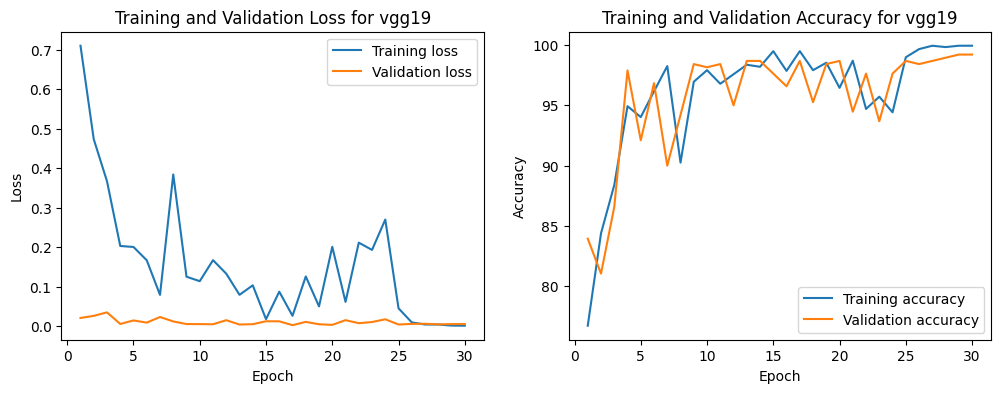

In [ ]:
# vgg19
train_and_evaluate(model, train_loader, val_loader, test_loader, params)

Train Epoch 1:   5%|▍         | 5/111 [00:00<00:09, 11.10it/s, accuracy=66.7, loss=0.977]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 1 	Loss: 0.641381 	Accuracy: 78.82%


Validation set: Average loss: 0.0326, Accuracy: 317/380 (83.42%)



Train Epoch 2:  17%|█▋        | 19/111 [00:02<00:10,  9.17it/s, accuracy=90.3, loss=0.304]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 2:  69%|██████▉   | 77/111 [00:06<00:02, 15.62it/s, accuracy=90.9, loss=0.293]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 2:  71%|███████   | 79/111 [00:06<00:02, 15.73it/s, accuracy=91, loss=0.293]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 2 	Loss: 0.271702 	Accuracy: 91.27%


Validation set: Average loss: 0.0110, Accuracy: 356/380 (93.68%)



Train Epoch 3:  19%|█▉        | 21/111 [00:01<00:06, 13.66it/s, accuracy=89, loss=0.333]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 3:  41%|████      | 45/111 [00:03<00:04, 14.61it/s, accuracy=92.6, loss=0.224]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 3 	Loss: 0.205280 	Accuracy: 93.30%


Validation set: Average loss: 0.0238, Accuracy: 342/380 (90.00%)



Train Epoch 4:   1%|          | 1/111 [00:00<00:30,  3.66it/s, accuracy=100, loss=0.0433]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 4:   9%|▉         | 10/111 [00:00<00:06, 14.65it/s, accuracy=94.9, loss=0.152]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 4:  11%|█         | 12/111 [00:00<00:06, 14.73it/s, accuracy=95.3, loss=0.141]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 4 	Loss: 0.148107 	Accuracy: 94.99%


Validation set: Average loss: 0.0041, Accuracy: 371/380 (97.63%)



Train Epoch 5:  16%|█▌        | 18/111 [00:01<00:05, 15.53it/s, accuracy=96.4, loss=0.0926]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 5:  31%|███       | 34/111 [00:02<00:04, 15.99it/s, accuracy=96.7, loss=0.0839]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 5 	Loss: 0.119499 	Accuracy: 96.11%


Validation set: Average loss: 0.0144, Accuracy: 350/380 (92.11%)



Train Epoch 6:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 6:  39%|███▊      | 43/111 [00:05<00:05, 12.47it/s, accuracy=94.9, loss=0.153]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 6 	Loss: 0.144653 	Accuracy: 95.72%


Validation set: Average loss: 0.0220, Accuracy: 337/380 (88.68%)



Train Epoch 7:   3%|▎         | 3/111 [00:00<00:11,  9.35it/s, accuracy=95.8, loss=0.128]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 7:   6%|▋         | 7/111 [00:00<00:08, 12.42it/s, accuracy=94.5, loss=0.167]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 7 	Loss: 0.128466 	Accuracy: 95.94%


Validation set: Average loss: 0.0078, Accuracy: 369/380 (97.11%)



Train Epoch 8:   3%|▎         | 3/111 [00:00<00:11,  9.36it/s, accuracy=96.9, loss=0.0767]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 8:  30%|██▉       | 33/111 [00:03<00:08,  9.37it/s, accuracy=98.5, loss=0.0597]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 8 	Loss: 0.088961 	Accuracy: 97.30%


Validation set: Average loss: 0.0091, Accuracy: 370/380 (97.37%)



Train Epoch 9:  24%|██▍       | 27/111 [00:01<00:05, 14.98it/s, accuracy=98.8, loss=0.0519]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 9:  24%|██▍       | 27/111 [00:02<00:05, 14.98it/s, accuracy=98.9, loss=0.0507]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 9:  30%|██▉       | 33/111 [00:02<00:07, 10.92it/s, accuracy=99.1, loss=0.0436]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 9 	Loss: 0.048068 	Accuracy: 98.70%


Validation set: Average loss: 0.0044, Accuracy: 374/380 (98.42%)



Train Epoch 10:  44%|████▍     | 49/111 [00:03<00:04, 13.85it/s, accuracy=97.8, loss=0.0596]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 10:  51%|█████▏    | 57/111 [00:04<00:03, 14.47it/s, accuracy=97.5, loss=0.0681]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 10 	Loss: 0.075875 	Accuracy: 97.18%


Validation set: Average loss: 0.0059, Accuracy: 369/380 (97.11%)



Train Epoch 11:  11%|█         | 12/111 [00:01<00:08, 11.60it/s, accuracy=96.9, loss=0.0826]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 11:  31%|███       | 34/111 [00:03<00:08,  8.82it/s, accuracy=96.9, loss=0.079]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 11:  31%|███       | 34/111 [00:03<00:08,  8.82it/s, accuracy=96.6, loss=0.0859]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 11 	Loss: 0.099393 	Accuracy: 96.96%


Validation set: Average loss: 0.0045, Accuracy: 373/380 (98.16%)



Train Epoch 12:   8%|▊         | 9/111 [00:00<00:08, 12.41it/s, accuracy=100, loss=0.018]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 12:  14%|█▎        | 15/111 [00:01<00:06, 14.26it/s, accuracy=100, loss=0.0154]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 12:  15%|█▌        | 17/111 [00:01<00:06, 14.88it/s, accuracy=100, loss=0.0162]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 12 	Loss: 0.066292 	Accuracy: 98.37%


Validation set: Average loss: 0.0515, Accuracy: 323/380 (85.00%)



Train Epoch 13:  19%|█▉        | 21/111 [00:01<00:05, 15.27it/s, accuracy=97.3, loss=0.103]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 13:  24%|██▍       | 27/111 [00:01<00:05, 14.81it/s, accuracy=97.2, loss=0.103]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 13 	Loss: 0.040057 	Accuracy: 98.82%


Validation set: Average loss: 0.0029, Accuracy: 374/380 (98.42%)



Train Epoch 14:  10%|▉         | 11/111 [00:01<00:10,  9.29it/s, accuracy=99, loss=0.0338]  /usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 14:  12%|█▏        | 13/111 [00:01<00:10,  9.58it/s, accuracy=99, loss=0.0324]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 14:  24%|██▍       | 27/111 [00:02<00:06, 13.09it/s, accuracy=98.9, loss=0.0293]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 14 	Loss: 0.044699 	Accuracy: 98.59%


Validation set: Average loss: 0.0043, Accuracy: 372/380 (97.89%)



Train Epoch 15:  23%|██▎       | 26/111 [00:01<00:05, 15.83it/s, accuracy=98.1, loss=0.0648]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 15:  70%|███████   | 78/111 [00:06<00:02, 12.23it/s, accuracy=96.4, loss=0.128]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 15 	Loss: 0.108490 	Accuracy: 96.90%


Validation set: Average loss: 0.0061, Accuracy: 372/380 (97.89%)



Train Epoch 16:  28%|██▊       | 31/111 [00:02<00:05, 15.26it/s, accuracy=98.8, loss=0.0443]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 16:  39%|███▊      | 43/111 [00:03<00:04, 15.24it/s, accuracy=98.4, loss=0.0492]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 16 	Loss: 0.036534 	Accuracy: 98.87%


Validation set: Average loss: 0.0041, Accuracy: 375/380 (98.68%)



Train Epoch 17:  28%|██▊       | 31/111 [00:02<00:05, 14.55it/s, accuracy=99.8, loss=0.0056] /usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 17:  51%|█████▏    | 57/111 [00:03<00:03, 15.08it/s, accuracy=99.5, loss=0.0154]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 17 	Loss: 0.028404 	Accuracy: 99.10%


Validation set: Average loss: 0.0034, Accuracy: 377/380 (99.21%)



Train Epoch 18:   5%|▍         | 5/111 [00:00<00:12,  8.50it/s, accuracy=97.9, loss=0.1]   /usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 18:  15%|█▌        | 17/111 [00:02<00:10,  8.98it/s, accuracy=99.3, loss=0.0473]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 18 	Loss: 0.019961 	Accuracy: 99.55%


Validation set: Average loss: 0.0038, Accuracy: 375/380 (98.68%)



Train Epoch 19:  19%|█▉        | 21/111 [00:01<00:05, 15.27it/s, accuracy=99.1, loss=0.0186]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 19 	Loss: 0.032346 	Accuracy: 98.99%


Validation set: Average loss: 0.0031, Accuracy: 376/380 (98.95%)



Train Epoch 20:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 20:  94%|█████████▎| 104/111 [00:06<00:00, 16.08it/s, accuracy=99.5, loss=0.0136]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 20 	Loss: 0.013296 	Accuracy: 99.55%


Validation set: Average loss: 0.0067, Accuracy: 371/380 (97.63%)



Train Epoch 21:   1%|          | 1/111 [00:00<00:43,  2.52it/s, accuracy=100, loss=0.000908]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 21:  92%|█████████▏| 102/111 [00:07<00:00, 16.22it/s, accuracy=97.2, loss=0.0766]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 21 	Loss: 0.074741 	Accuracy: 97.24%


Validation set: Average loss: 0.0132, Accuracy: 354/380 (93.16%)



Train Epoch 22:   5%|▍         | 5/111 [00:00<00:09, 11.26it/s, accuracy=96.2, loss=0.143]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 22:  39%|███▊      | 43/111 [00:03<00:05, 12.68it/s, accuracy=96.1, loss=0.125]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 22 	Loss: 0.077219 	Accuracy: 97.63%


Validation set: Average loss: 0.0102, Accuracy: 372/380 (97.89%)



Train Epoch 23:  28%|██▊       | 31/111 [00:02<00:05, 15.41it/s, accuracy=98.6, loss=0.0451]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 23:  63%|██████▎   | 70/111 [00:04<00:02, 15.14it/s, accuracy=99.2, loss=0.0305]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 23 	Loss: 0.027013 	Accuracy: 99.21%


Validation set: Average loss: 0.0043, Accuracy: 375/380 (98.68%)



Train Epoch 24:   5%|▍         | 5/111 [00:00<00:09, 11.33it/s, accuracy=100, loss=0.0112]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 24:  14%|█▎        | 15/111 [00:01<00:06, 14.64it/s, accuracy=100, loss=0.00653]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 24 	Loss: 0.026754 	Accuracy: 99.21%


Validation set: Average loss: 0.0021, Accuracy: 376/380 (98.95%)



Train Epoch 25:  17%|█▋        | 19/111 [00:01<00:08, 11.15it/s, accuracy=98.8, loss=0.0295]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 25:  50%|████▉     | 55/111 [00:05<00:05,  9.58it/s, accuracy=99.2, loss=0.0205]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 25 	Loss: 0.045183 	Accuracy: 98.31%


Validation set: Average loss: 0.0085, Accuracy: 370/380 (97.37%)



Train Epoch 26:   1%|          | 1/111 [00:00<00:25,  4.40it/s, accuracy=100, loss=0.0195]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 26:  14%|█▎        | 15/111 [00:01<00:06, 14.43it/s, accuracy=97.3, loss=0.0732]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 26 	Loss: 0.045176 	Accuracy: 98.70%


Validation set: Average loss: 0.0053, Accuracy: 373/380 (98.16%)



Train Epoch 27:  10%|▉         | 11/111 [00:00<00:07, 13.72it/s, accuracy=100, loss=0.00462]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 27:  12%|█▏        | 13/111 [00:01<00:06, 14.71it/s, accuracy=100, loss=0.00432]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 27:  15%|█▌        | 17/111 [00:01<00:06, 15.02it/s, accuracy=100, loss=0.00382]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 27 	Loss: 0.023850 	Accuracy: 99.32%


Validation set: Average loss: 0.0028, Accuracy: 376/380 (98.95%)



Train Epoch 28:  42%|████▏     | 47/111 [00:04<00:04, 14.08it/s, accuracy=100, loss=0.00463]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 28:  42%|████▏     | 47/111 [00:04<00:04, 14.08it/s, accuracy=100, loss=0.00495]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 28:  58%|█████▊    | 64/111 [00:05<00:03, 15.04it/s, accuracy=100, loss=0.00404]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 28 	Loss: 0.010407 	Accuracy: 99.77%


Validation set: Average loss: 0.0044, Accuracy: 371/380 (97.63%)



Train Epoch 29:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 29:   3%|▎         | 3/111 [00:00<00:10, 10.07it/s, accuracy=100, loss=0.0122] /usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 29 	Loss: 0.011123 	Accuracy: 99.61%


Validation set: Average loss: 0.0039, Accuracy: 373/380 (98.16%)



Train Epoch 30:   0%|          | 0/111 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 30 	Loss: 0.037922 	Accuracy: 98.82%


Validation set: Average loss: 0.0049, Accuracy: 375/380 (98.68%)



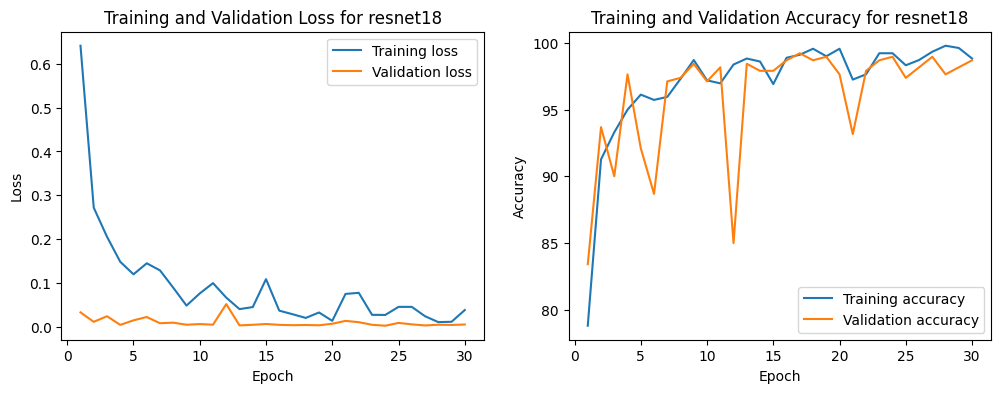

In [ ]:
# Resnet18
train_and_evaluate(model, train_loader, val_loader, test_loader, params)

Train Epoch 1:   5%|▌         | 3/56 [00:01<00:14,  3.63it/s, accuracy=53.1, loss=1.08]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 1:   7%|▋         | 4/56 [00:01<00:11,  4.50it/s, accuracy=55.5, loss=1.13]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 1:  16%|█▌        | 9/56 [00:01<00:06,  7.28it/s, accuracy=65.6, loss=0.908]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 1:  18%|█▊        | 10/56 [00:01<00:05,  7.69it/s, accuracy=65.9, loss=0.891]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 1 	Loss: 0.545169 	Accuracy: 80.39%


Validation:  58%|█████▊    | 7/12 [00:01<00:01,  4.44it/s, accuracy=87.5, loss=0.726]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0250, Accuracy: 330/380 (86.84%)



Train Epoch 2:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 2:  29%|██▊       | 16/56 [00:02<00:05,  6.85it/s, accuracy=90.4, loss=0.309]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 2 	Loss: 0.239136 	Accuracy: 92.79%


Validation:  58%|█████▊    | 7/12 [00:01<00:01,  3.78it/s, accuracy=92.2, loss=0.243]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0068, Accuracy: 353/380 (92.89%)



Train Epoch 3:  16%|█▌        | 9/56 [00:02<00:14,  3.14it/s, accuracy=93.4, loss=0.214]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 3:  30%|███       | 17/56 [00:04<00:06,  5.89it/s, accuracy=91.4, loss=0.245]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 3 	Loss: 0.183159 	Accuracy: 93.92%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.48it/s, accuracy=95.1, loss=0.161]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0036, Accuracy: 366/380 (96.32%)



Train Epoch 4:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 4:  34%|███▍      | 19/56 [00:04<00:09,  3.96it/s, accuracy=96.4, loss=0.117]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 4 	Loss: 0.115337 	Accuracy: 96.34%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.08it/s, accuracy=96.5, loss=0.113]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0037, Accuracy: 367/380 (96.58%)



Train Epoch 5:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 5 	Loss: 0.089307 	Accuracy: 97.75%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.14it/s, accuracy=97.3, loss=0.121]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.14it/s, accuracy=97.7, loss=0.11] /usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0032, Accuracy: 370/380 (97.37%)



Train Epoch 6:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 6:  34%|███▍      | 19/56 [00:03<00:05,  6.27it/s, accuracy=96.5, loss=0.104]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 6:  34%|███▍      | 19/56 [00:03<00:05,  6.27it/s, accuracy=96.2, loss=0.105]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 6 	Loss: 0.099250 	Accuracy: 96.39%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  6.56it/s, accuracy=95.5, loss=0.175]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation:  58%|█████▊    | 7/12 [00:01<00:00,  6.56it/s, accuracy=95.7, loss=0.162]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0043, Accuracy: 365/380 (96.05%)



Train Epoch 7:   4%|▎         | 2/56 [00:00<00:14,  3.66it/s, accuracy=98.4, loss=0.0511]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 7:  66%|██████▌   | 37/56 [00:05<00:02,  6.66it/s, accuracy=98.6, loss=0.0427]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 7 	Loss: 0.042374 	Accuracy: 98.59%


Validation:  58%|█████▊    | 7/12 [00:01<00:01,  4.32it/s, accuracy=96.4, loss=0.0806]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0046, Accuracy: 364/380 (95.79%)



Train Epoch 8:  18%|█▊        | 10/56 [00:02<00:11,  4.14it/s, accuracy=98.8, loss=0.0614]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 8:  54%|█████▎    | 30/56 [00:06<00:04,  6.30it/s, accuracy=98.3, loss=0.0628]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 8:  55%|█████▌    | 31/56 [00:06<00:03,  6.64it/s, accuracy=98.3, loss=0.0617]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 8 	Loss: 0.057103 	Accuracy: 98.25%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  6.62it/s, accuracy=98, loss=0.0535]  /usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0021, Accuracy: 373/380 (98.16%)



Train Epoch 9:  16%|█▌        | 9/56 [00:01<00:11,  4.26it/s, accuracy=98.3, loss=0.075]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 9:  43%|████▎     | 24/56 [00:05<00:07,  4.53it/s, accuracy=98.7, loss=0.049]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 9 	Loss: 0.036583 	Accuracy: 98.82%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  6.89it/s, accuracy=97.7, loss=0.093]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0035, Accuracy: 368/380 (96.84%)



Train Epoch 10:  23%|██▎       | 13/56 [00:02<00:07,  6.04it/s, accuracy=98.6, loss=0.0633]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 10:  52%|█████▏    | 29/56 [00:04<00:04,  6.07it/s, accuracy=98.9, loss=0.046]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 10 	Loss: 0.033488 	Accuracy: 99.21%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.11it/s, accuracy=98.8, loss=0.0193]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0009, Accuracy: 374/380 (98.42%)



Train Epoch 11:   7%|▋         | 4/56 [00:01<00:10,  5.10it/s, accuracy=99.4, loss=0.0127]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 11:  43%|████▎     | 24/56 [00:04<00:05,  5.90it/s, accuracy=99.1, loss=0.016]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 11:  45%|████▍     | 25/56 [00:04<00:04,  6.21it/s, accuracy=99.1, loss=0.0162]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 11 	Loss: 0.047251 	Accuracy: 98.87%


Validation:  58%|█████▊    | 7/12 [00:02<00:01,  3.81it/s, accuracy=94.2, loss=0.291]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0076, Accuracy: 360/380 (94.74%)



Train Epoch 12:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 12:  14%|█▍        | 8/56 [00:01<00:07,  6.01it/s, accuracy=98.4, loss=0.0377]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 12 	Loss: 0.072443 	Accuracy: 97.30%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  5.87it/s, accuracy=98.4, loss=0.0336]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0008, Accuracy: 376/380 (98.95%)



Train Epoch 13:  11%|█         | 6/56 [00:02<00:13,  3.57it/s, accuracy=97.4, loss=0.0411]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 13:  16%|█▌        | 9/56 [00:03<00:12,  3.76it/s, accuracy=97.9, loss=0.0437]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 13 	Loss: 0.034961 	Accuracy: 98.65%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  6.87it/s, accuracy=94.2, loss=0.185]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0050, Accuracy: 361/380 (95.00%)



Train Epoch 14:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 14:  45%|████▍     | 25/56 [00:06<00:08,  3.55it/s, accuracy=99.5, loss=0.0175]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 14 	Loss: 0.031123 	Accuracy: 99.21%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.14it/s, accuracy=98.7, loss=0.0228]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0010, Accuracy: 375/380 (98.68%)



Train Epoch 15:   4%|▎         | 2/56 [00:00<00:13,  3.87it/s, accuracy=100, loss=0.00112]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 15:   5%|▌         | 3/56 [00:00<00:11,  4.61it/s, accuracy=100, loss=0.00108]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 15 	Loss: 0.054624 	Accuracy: 98.14%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.57it/s, accuracy=94.1, loss=0.236]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0052, Accuracy: 364/380 (95.79%)



Train Epoch 16:  16%|█▌        | 9/56 [00:01<00:08,  5.67it/s, accuracy=96.9, loss=0.116]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 16:  21%|██▏       | 12/56 [00:02<00:06,  6.41it/s, accuracy=96.9, loss=0.108]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 16 	Loss: 0.105589 	Accuracy: 97.24%


Validation:  58%|█████▊    | 7/12 [00:01<00:01,  4.82it/s, accuracy=96.1, loss=0.102]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0033, Accuracy: 366/380 (96.32%)



Train Epoch 17:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 17:   5%|▌         | 3/56 [00:00<00:12,  4.12it/s, accuracy=99, loss=0.0586]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 17 	Loss: 0.032849 	Accuracy: 98.87%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.06it/s, accuracy=99.1, loss=0.0412]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.06it/s, accuracy=99.2, loss=0.0373]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0012, Accuracy: 376/380 (98.95%)



Train Epoch 18:   7%|▋         | 4/56 [00:01<00:12,  4.09it/s, accuracy=100, loss=0.00405]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 18:  68%|██████▊   | 38/56 [00:07<00:02,  6.65it/s, accuracy=99.8, loss=0.00701]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 18 	Loss: 0.008085 	Accuracy: 99.72%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.26it/s, accuracy=99.2, loss=0.0118]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0007, Accuracy: 377/380 (99.21%)



Train Epoch 19:  11%|█         | 6/56 [00:01<00:07,  6.49it/s, accuracy=99.5, loss=0.0134]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 19:  55%|█████▌    | 31/56 [00:06<00:05,  4.42it/s, accuracy=99.9, loss=0.00638]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 19 	Loss: 0.013592 	Accuracy: 99.66%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.26it/s, accuracy=95.5, loss=0.108]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0032, Accuracy: 366/380 (96.32%)



Train Epoch 20:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 20:  27%|██▋       | 15/56 [00:02<00:06,  6.62it/s, accuracy=99.8, loss=0.0135]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 20 	Loss: 0.013914 	Accuracy: 99.61%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  6.67it/s, accuracy=98.7, loss=0.0555]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0016, Accuracy: 374/380 (98.42%)



Train Epoch 21:   2%|▏         | 1/56 [00:00<00:25,  2.17it/s, accuracy=100, loss=0.00339]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 21:   4%|▎         | 2/56 [00:00<00:14,  3.79it/s, accuracy=100, loss=0.00352]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 21:  11%|█         | 6/56 [00:01<00:07,  6.30it/s, accuracy=100, loss=0.00514]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 21 	Loss: 0.031162 	Accuracy: 99.15%


Validation:  58%|█████▊    | 7/12 [00:01<00:01,  4.05it/s, accuracy=98.2, loss=0.0997]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0021, Accuracy: 374/380 (98.42%)



Train Epoch 22:   2%|▏         | 1/56 [00:00<00:34,  1.59it/s, accuracy=96.9, loss=0.0728]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 22 	Loss: 0.019616 	Accuracy: 99.32%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.12it/s, accuracy=95.5, loss=0.139]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0033, Accuracy: 368/380 (96.84%)



Train Epoch 23:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 23:  23%|██▎       | 13/56 [00:02<00:08,  4.86it/s, accuracy=99.8, loss=0.00617]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 23 	Loss: 0.028782 	Accuracy: 99.10%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.09it/s, accuracy=98.8, loss=0.062] /usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0017, Accuracy: 375/380 (98.68%)



Train Epoch 24:  29%|██▊       | 16/56 [00:02<00:06,  6.31it/s, accuracy=98.4, loss=0.047]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Train Epoch 24:  30%|███       | 17/56 [00:02<00:05,  6.53it/s, accuracy=98.3, loss=0.047]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 24:  32%|███▏      | 18/56 [00:02<00:05,  6.82it/s, accuracy=98.4, loss=0.0445]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 24 	Loss: 0.048325 	Accuracy: 98.31%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  6.56it/s, accuracy=94.5, loss=0.242]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0061, Accuracy: 362/380 (95.26%)



Train Epoch 25:   2%|▏         | 1/56 [00:00<00:24,  2.26it/s, accuracy=100, loss=0.00172]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 25:  16%|█▌        | 9/56 [00:01<00:07,  6.04it/s, accuracy=96.9, loss=0.108]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 25 	Loss: 0.071327 	Accuracy: 97.86%


Validation:  58%|█████▊    | 7/12 [00:01<00:01,  4.96it/s, accuracy=96, loss=0.111]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0029, Accuracy: 367/380 (96.58%)



Train Epoch 26:  11%|█         | 6/56 [00:01<00:10,  4.94it/s, accuracy=100, loss=0.0139]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 26:  21%|██▏       | 12/56 [00:02<00:06,  6.52it/s, accuracy=99.7, loss=0.0154]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 26 	Loss: 0.020227 	Accuracy: 99.44%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.08it/s, accuracy=97.8, loss=0.0569]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.08it/s, accuracy=98, loss=0.0503]  /usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0016, Accuracy: 374/380 (98.42%)



Train Epoch 27:  14%|█▍        | 8/56 [00:02<00:11,  4.14it/s, accuracy=99.2, loss=0.0186]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 27:  43%|████▎     | 24/56 [00:06<00:06,  4.64it/s, accuracy=99.5, loss=0.0151]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 27 	Loss: 0.043849 	Accuracy: 98.14%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  6.99it/s, accuracy=92.4, loss=0.404]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0096, Accuracy: 359/380 (94.47%)



Train Epoch 28:  11%|█         | 6/56 [00:01<00:08,  5.86it/s, accuracy=93.8, loss=0.142]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 28:  79%|███████▊  | 44/56 [00:09<00:02,  4.20it/s, accuracy=98.2, loss=0.0558]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 28 	Loss: 0.046326 	Accuracy: 98.54%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  6.97it/s, accuracy=99.2, loss=0.0778]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0018, Accuracy: 377/380 (99.21%)



Train Epoch 29:   9%|▉         | 5/56 [00:01<00:09,  5.27it/s, accuracy=99.4, loss=0.0138]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Train Epoch 29:  34%|███▍      | 19/56 [00:03<00:06,  6.15it/s, accuracy=99.7, loss=0.0099]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 29 	Loss: 0.013625 	Accuracy: 99.55%


Validation:  58%|█████▊    | 7/12 [00:01<00:01,  4.45it/s, accuracy=98.7, loss=0.0838]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0026, Accuracy: 374/380 (98.42%)



Train Epoch 30:  12%|█▎        | 7/56 [00:01<00:08,  6.04it/s, accuracy=99.6, loss=0.0107]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Train Epoch: 30 	Loss: 0.005595 	Accuracy: 99.83%


Validation:  58%|█████▊    | 7/12 [00:01<00:00,  7.14it/s, accuracy=97.3, loss=0.0696]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Validation set: Average loss: 0.0021, Accuracy: 372/380 (97.89%)



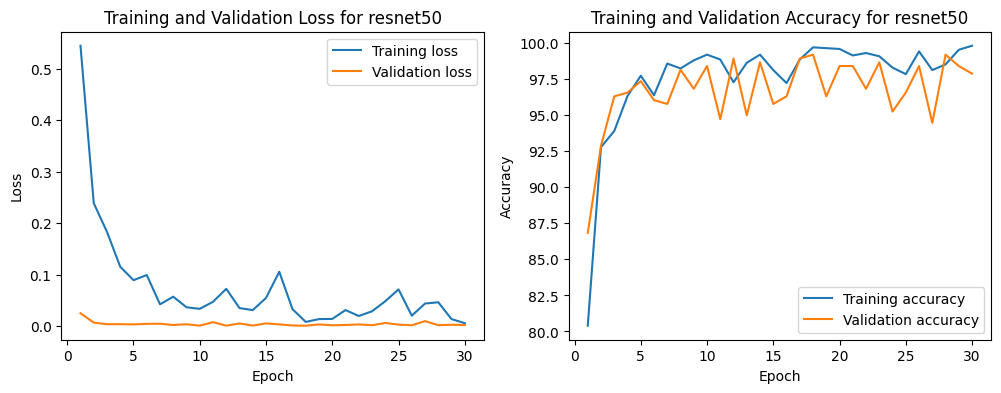

In [ ]:
# Resnet50
train_and_evaluate(model, train_loader, val_loader, test_loader, params)

In [ ]:
def test(test_loader, model, criterion, params, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    y_true, y_pred = [], []

    progress_bar = tqdm(test_loader, desc='Test', leave=False)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(params['device']), target.to(params['device'])
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            y_true.extend(target.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            progress_bar.set_postfix(loss=test_loss/(batch_idx+1), accuracy=100.*correct/total)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap="cividis")
    plt.title(f'Confusion Matrix for {params["model"]} of epoch_{epoch}')
    plt.savefig(f"./models_{params['model']}/figures/confusion_matrix_{params['model']}_epoch_{epoch}.png")
    plt.show()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / total
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({test_acc:.2f}%)\n')

    # Print precision, recall, and F1 score
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']

    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}\n')

    return test_loss, test_acc, precision, recall, f1_score

In [ ]:
def test_best_model(model, test_loader, params):
    print(f"Testing the best {params['model']} model...")
    weight_files = glob.glob(f"./models_{params['model']}/weights/weight_model_epoch_*_{params['model']}.pth")
    metrics = []

    for weight_file in weight_files:
        epoch = int(weight_file.split('_')[-2])
        print("-------Epoch-------", epoch)
        print(f"Evaluating model weights: {weight_file}")
        # print(model)
        model.load_state_dict(torch.load(weight_file))
        criterion = nn.CrossEntropyLoss()
        test_loss, test_acc, precision, recall, f1_score = test(test_loader, model, criterion, params, epoch)

        metrics.append({
            'epoch': epoch,
            'weight_file': weight_file,
            'test_loss': test_loss,
            'test_acc': test_acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        })

    return metrics

Testing the best vgg16 model...
-------Epoch------- 1
Evaluating model weights: ./models_vgg16/weights/weight_model_epoch_1_vgg16.pth


Test:  29%|██▉       | 7/24 [00:01<00:02,  7.42it/s, accuracy=75, loss=0.537]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


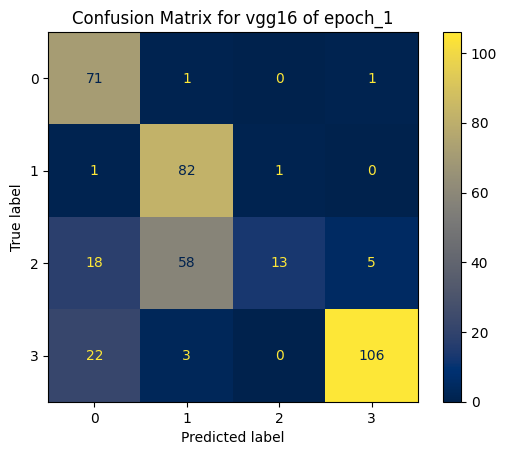

Test set: Average loss: 0.0360, Accuracy: 272/382 (71.20%)

Precision: 0.7994, Recall: 0.7120, F1-score: 0.6633

-------Epoch------- 2
Evaluating model weights: ./models_vgg16/weights/weight_model_epoch_2_vgg16.pth


Test:  29%|██▉       | 7/24 [00:00<00:01, 12.90it/s, accuracy=83.6, loss=0.587]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


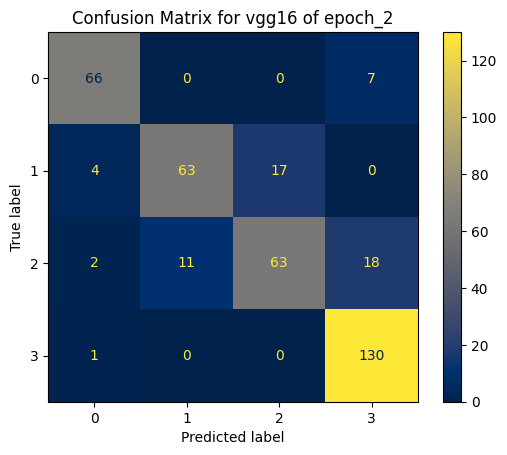

Test set: Average loss: 0.0324, Accuracy: 322/382 (84.29%)

Precision: 0.8414, Recall: 0.8429, F1-score: 0.8381

-------Epoch------- 4
Evaluating model weights: ./models_vgg16/weights/weight_model_epoch_4_vgg16.pth


Test:  29%|██▉       | 7/24 [00:00<00:01, 12.58it/s, accuracy=88.3, loss=0.57]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


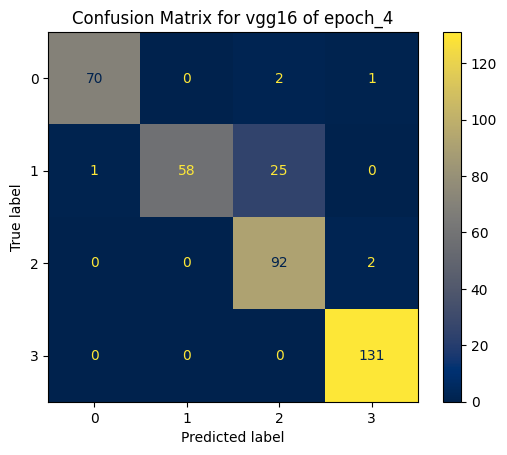

Test set: Average loss: 0.0252, Accuracy: 351/382 (91.88%)

Precision: 0.9338, Recall: 0.9188, F1-score: 0.9170

-------Epoch------- 5
Evaluating model weights: ./models_vgg16/weights/weight_model_epoch_5_vgg16.pth


Test:  33%|███▎      | 8/24 [00:01<00:02,  7.47it/s, accuracy=95.1, loss=0.228]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


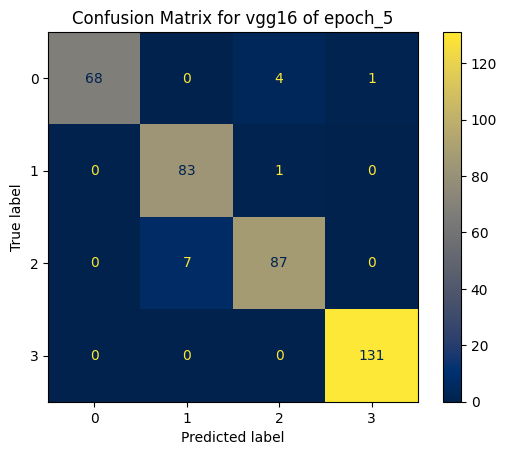

Test set: Average loss: 0.0080, Accuracy: 369/382 (96.60%)

Precision: 0.9669, Recall: 0.9660, F1-score: 0.9659

-------Epoch------- 7
Evaluating model weights: ./models_vgg16/weights/weight_model_epoch_7_vgg16.pth


Test:  29%|██▉       | 7/24 [00:00<00:01, 11.51it/s, accuracy=96.4, loss=0.0771]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


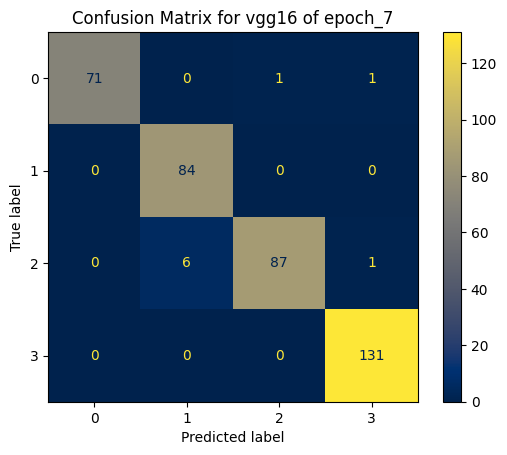

Test set: Average loss: 0.0062, Accuracy: 373/382 (97.64%)

Precision: 0.9774, Recall: 0.9764, F1-score: 0.9763

All the metrics are: 
[{'epoch': 1, 'weight_file': './models_vgg16/weights/weight_model_epoch_1_vgg16.pth', 'test_loss': 0.03603407927832678, 'test_acc': 71.20418848167539, 'precision': 0.7994187858389428, 'recall': 0.7120418848167539, 'f1_score': 0.6632753417205821}, {'epoch': 2, 'weight_file': './models_vgg16/weights/weight_model_epoch_2_vgg16.pth', 'test_loss': 0.03235868653233763, 'test_acc': 84.29319371727749, 'precision': 0.841386076584945, 'recall': 0.8429319371727748, 'f1_score': 0.838081718273043}, {'epoch': 4, 'weight_file': './models_vgg16/weights/weight_model_epoch_4_vgg16.pth', 'test_loss': 0.02523916158386316, 'test_acc': 91.8848167539267, 'precision': 0.933799120608856, 'recall': 0.918848167539267, 'f1_score': 0.9170439780063592}, {'epoch': 5, 'weight_file': './models_vgg16/weights/weight_model_epoch_5_vgg16.pth', 'test_loss': 0.008048349686993373, 'test_acc':

In [ ]:
# ------------vgg16

metrics = test_best_model(model, test_loader, params)

print("All the metrics are: ", metrics, sep='\n')

Testing the best vgg19 model...
-------Epoch------- 1
Evaluating model weights: ./models_vgg19/weights/weight_model_epoch_1_vgg19.pth


Test:  58%|█████▊    | 14/24 [00:38<00:24,  2.50s/it, accuracy=85.3, loss=0.34]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


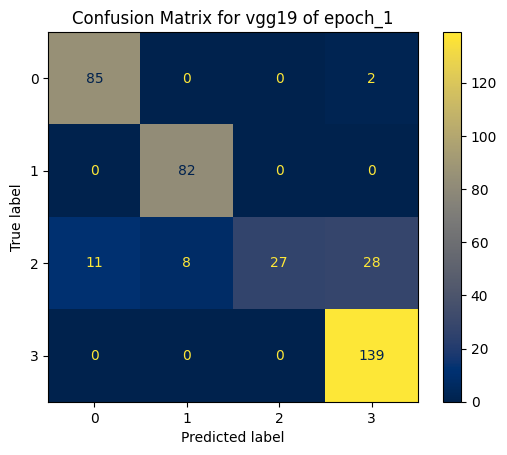

Test set: Average loss: 0.0185, Accuracy: 333/382 (87.17%)

Precision: 0.8902, Recall: 0.8717, F1-score: 0.8482

-------Epoch------- 3
Evaluating model weights: ./models_vgg19/weights/weight_model_epoch_3_vgg19.pth


Test:  58%|█████▊    | 14/24 [00:01<00:00, 13.73it/s, accuracy=86.7, loss=0.457]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


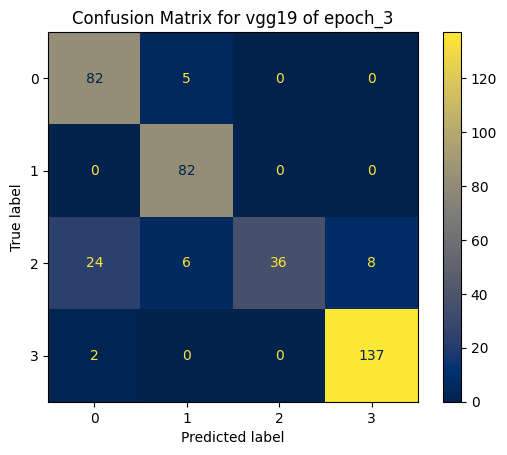

Test set: Average loss: 0.0257, Accuracy: 337/382 (88.22%)

Precision: 0.8997, Recall: 0.8822, F1-score: 0.8706

-------Epoch------- 4
Evaluating model weights: ./models_vgg19/weights/weight_model_epoch_4_vgg19.pth


Test:  62%|██████▎   | 15/24 [00:01<00:00, 15.36it/s, accuracy=97.9, loss=0.0654]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


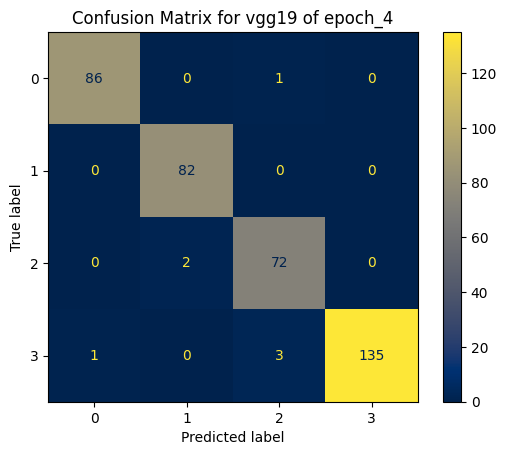

Test set: Average loss: 0.0042, Accuracy: 375/382 (98.17%)

Precision: 0.9821, Recall: 0.9817, F1-score: 0.9817

-------Epoch------- 9
Evaluating model weights: ./models_vgg19/weights/weight_model_epoch_9_vgg19.pth


Test:  54%|█████▍    | 13/24 [00:01<00:00, 13.24it/s, accuracy=98.7, loss=0.0334]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


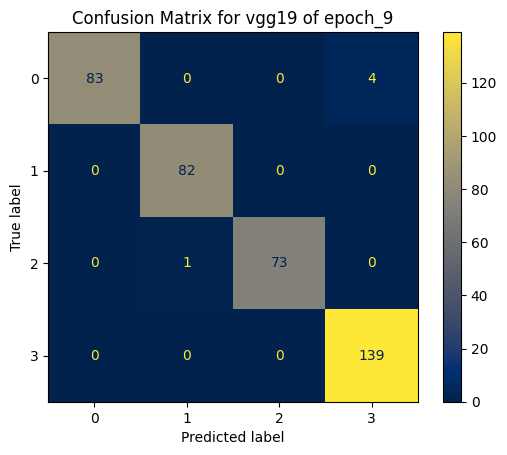

Test set: Average loss: 0.0020, Accuracy: 377/382 (98.69%)

Precision: 0.9872, Recall: 0.9869, F1-score: 0.9869

-------Epoch------- 13
Evaluating model weights: ./models_vgg19/weights/weight_model_epoch_13_vgg19.pth


Test:  54%|█████▍    | 13/24 [00:01<00:00, 11.09it/s, accuracy=99.5, loss=0.0331]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Test:  54%|█████▍    | 13/24 [00:01<00:00, 11.09it/s, accuracy=99.6, loss=0.0308]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


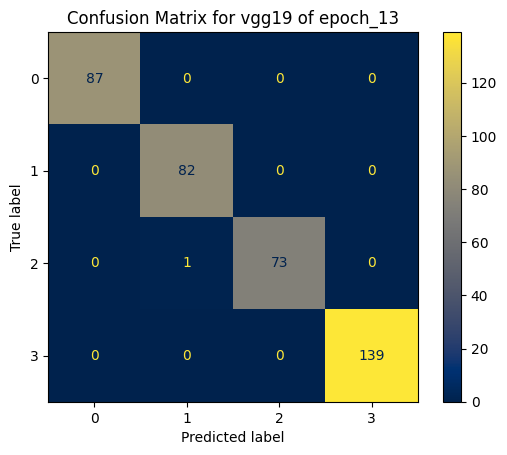

Test set: Average loss: 0.0012, Accuracy: 381/382 (99.74%)

Precision: 0.9974, Recall: 0.9974, F1-score: 0.9974

-------Epoch------- 28
Evaluating model weights: ./models_vgg19/weights/weight_model_epoch_28_vgg19.pth


Test:  54%|█████▍    | 13/24 [00:01<00:00, 14.79it/s, accuracy=99.6, loss=0.00604]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


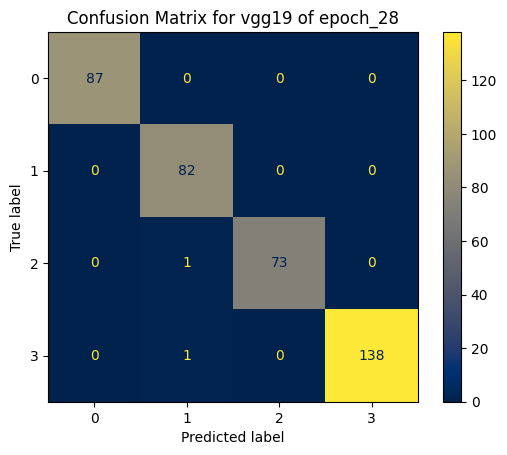

Test set: Average loss: 0.0005, Accuracy: 380/382 (99.48%)

Precision: 0.9949, Recall: 0.9948, F1-score: 0.9948

-------Epoch------- 29
Evaluating model weights: ./models_vgg19/weights/weight_model_epoch_29_vgg19.pth


Test:  62%|██████▎   | 15/24 [00:01<00:00, 16.47it/s, accuracy=100, loss=0.00204]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


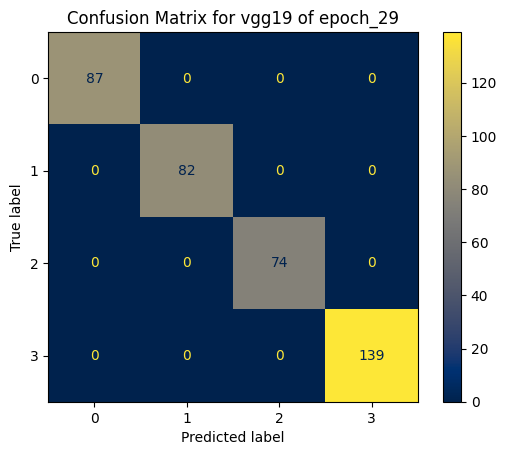

Test set: Average loss: 0.0003, Accuracy: 382/382 (100.00%)

Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000

All the metrics are: 
[{'epoch': 1, 'weight_file': './models_vgg19/weights/weight_model_epoch_1_vgg19.pth', 'test_loss': 0.018546312033193898, 'test_acc': 87.17277486910994, 'precision': 0.8902298557541711, 'recall': 0.8717277486910995, 'f1_score': 0.848248989632089}, {'epoch': 3, 'weight_file': './models_vgg19/weights/weight_model_epoch_3_vgg19.pth', 'test_loss': 0.025710588767246894, 'test_acc': 88.21989528795811, 'precision': 0.8997059301233806, 'recall': 0.8821989528795812, 'f1_score': 0.8705679122882868}, {'epoch': 4, 'weight_file': './models_vgg19/weights/weight_model_epoch_4_vgg19.pth', 'test_loss': 0.00419452417329812, 'test_acc': 98.16753926701571, 'precision': 0.9820756078678371, 'recall': 0.981675392670157, 'f1_score': 0.9817352123363327}, {'epoch': 9, 'weight_file': './models_vgg19/weights/weight_model_epoch_9_vgg19.pth', 'test_loss': 0.001953826219991271, 'test

In [ ]:
# ------------vgg19

metrics = test_best_model(model, test_loader, params)

print("All the metrics are: ", metrics, sep='\n')

Testing the best resnet18 model...
-------Epoch------- 1
Evaluating model weights: ./models_resnet18/weights/weight_model_epoch_1_resnet18.pth


Test:  54%|█████▍    | 13/24 [00:00<00:00, 16.59it/s, accuracy=87.5, loss=0.378]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


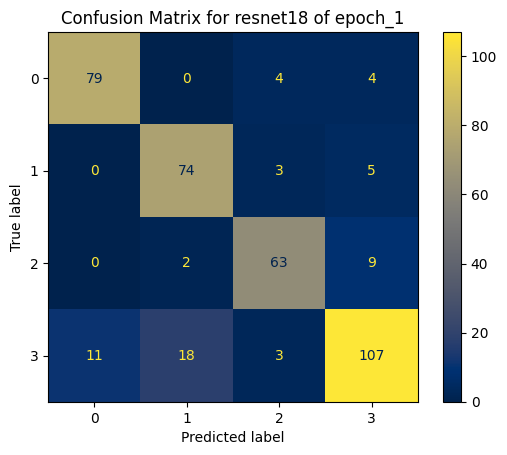

Test set: Average loss: 0.0268, Accuracy: 323/382 (84.55%)

Precision: 0.8476, Recall: 0.8455, F1-score: 0.8448

-------Epoch------- 2
Evaluating model weights: ./models_resnet18/weights/weight_model_epoch_2_resnet18.pth


Test:  58%|█████▊    | 14/24 [00:00<00:00, 17.43it/s, accuracy=95.1, loss=0.157]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


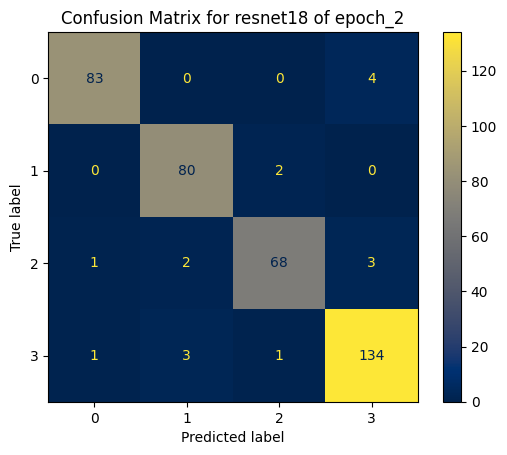

Test set: Average loss: 0.0090, Accuracy: 365/382 (95.55%)

Precision: 0.9558, Recall: 0.9555, F1-score: 0.9554

-------Epoch------- 4
Evaluating model weights: ./models_resnet18/weights/weight_model_epoch_4_resnet18.pth


Test:  58%|█████▊    | 14/24 [00:00<00:00, 17.28it/s, accuracy=97.8, loss=0.0678]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


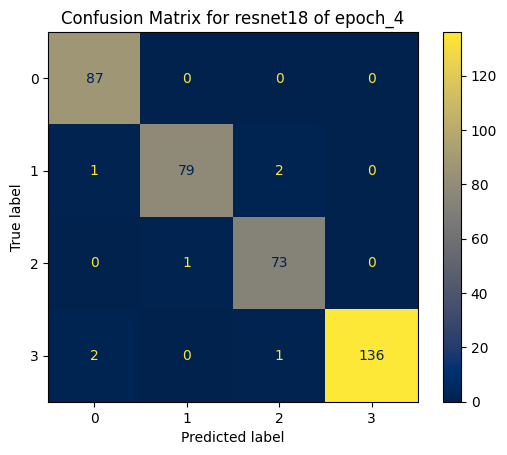

Test set: Average loss: 0.0033, Accuracy: 375/382 (98.17%)

Precision: 0.9821, Recall: 0.9817, F1-score: 0.9817

-------Epoch------- 9
Evaluating model weights: ./models_resnet18/weights/weight_model_epoch_9_resnet18.pth


Test:  54%|█████▍    | 13/24 [00:01<00:00, 11.28it/s, accuracy=99.6, loss=0.0208]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


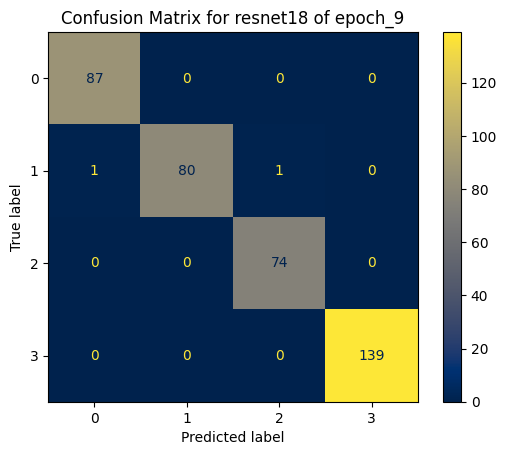

Test set: Average loss: 0.0012, Accuracy: 380/382 (99.48%)

Precision: 0.9948, Recall: 0.9948, F1-score: 0.9947

-------Epoch------- 16
Evaluating model weights: ./models_resnet18/weights/weight_model_epoch_16_resnet18.pth


Test:  62%|██████▎   | 15/24 [00:00<00:00, 16.72it/s, accuracy=99.6, loss=0.0062]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


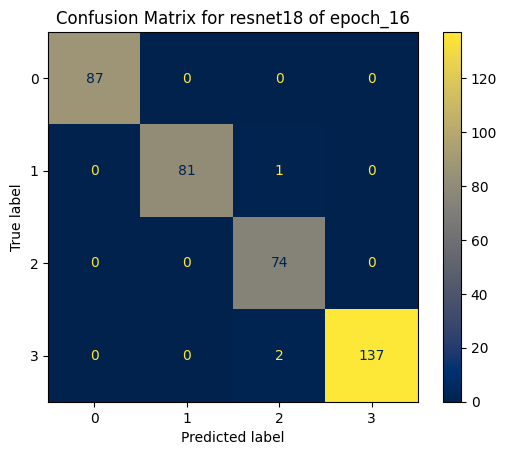

Test set: Average loss: 0.0016, Accuracy: 379/382 (99.21%)

Precision: 0.9925, Recall: 0.9921, F1-score: 0.9922

-------Epoch------- 17
Evaluating model weights: ./models_resnet18/weights/weight_model_epoch_17_resnet18.pth


Test:  58%|█████▊    | 14/24 [00:00<00:00, 16.74it/s, accuracy=100, loss=0.00389]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


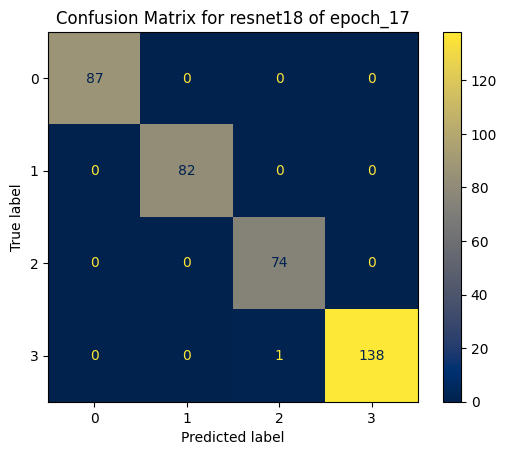

Test set: Average loss: 0.0005, Accuracy: 381/382 (99.74%)

Precision: 0.9974, Recall: 0.9974, F1-score: 0.9974

All the metrics are: 
[{'epoch': 1, 'weight_file': './models_resnet18/weights/weight_model_epoch_1_resnet18.pth', 'test_loss': 0.026801541720697392, 'test_acc': 84.55497382198953, 'precision': 0.8475572561640276, 'recall': 0.8455497382198953, 'f1_score': 0.8448125032892981}, {'epoch': 2, 'weight_file': './models_resnet18/weights/weight_model_epoch_2_resnet18.pth', 'test_loss': 0.00902015121936486, 'test_acc': 95.54973821989529, 'precision': 0.9557642460247839, 'recall': 0.9554973821989529, 'f1_score': 0.955439121008241}, {'epoch': 4, 'weight_file': './models_resnet18/weights/weight_model_epoch_4_resnet18.pth', 'test_loss': 0.003331756114433105, 'test_acc': 98.16753926701571, 'precision': 0.9820783962524111, 'recall': 0.981675392670157, 'f1_score': 0.9817042811546907}, {'epoch': 9, 'weight_file': './models_resnet18/weights/weight_model_epoch_9_resnet18.pth', 'test_loss': 0.00

In [ ]:
# ------------resnet18

metrics = test_best_model(model, test_loader, params)

print("All the metrics are: ", metrics, sep='\n')

Testing the best resnet50 model...
-------Epoch------- 1
Evaluating model weights: ./models_resnet50/weights/weight_model_epoch_1_resnet50.pth


Test:  42%|████▏     | 5/12 [00:01<00:01,  6.57it/s, accuracy=84.8, loss=1.2] /usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Test:  58%|█████▊    | 7/12 [00:01<00:00,  6.97it/s, accuracy=84.8, loss=1.2]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Test:  75%|███████▌  | 9/12 [00:01<00:00,  7.27it/s, accuracy=85.8, loss=1.19]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


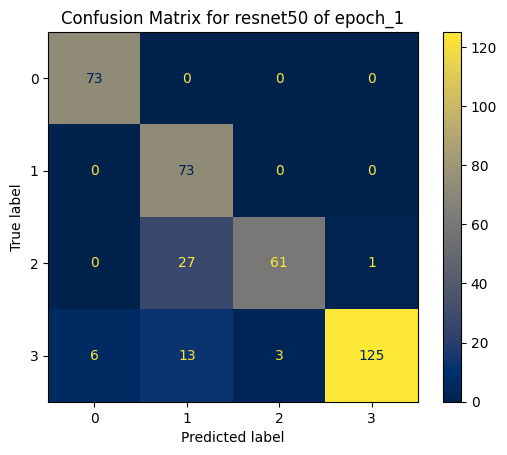

Test set: Average loss: 0.0336, Accuracy: 332/382 (86.91%)

Precision: 0.9039, Recall: 0.8691, F1-score: 0.8717

-------Epoch------- 2
Evaluating model weights: ./models_resnet50/weights/weight_model_epoch_2_resnet50.pth


Test:  42%|████▏     | 5/12 [00:00<00:01,  6.21it/s, accuracy=91.7, loss=0.277]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Test:  75%|███████▌  | 9/12 [00:01<00:00,  7.54it/s, accuracy=93.1, loss=0.282]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


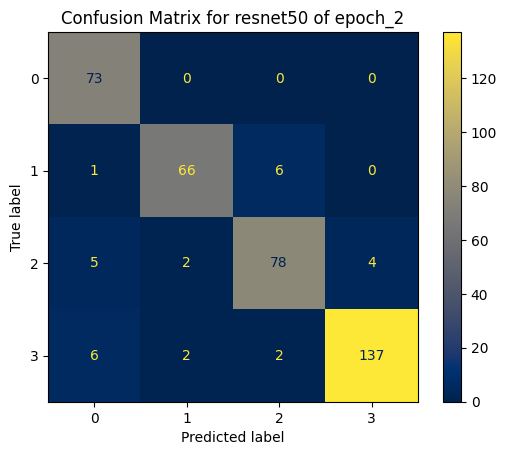

Test set: Average loss: 0.0089, Accuracy: 354/382 (92.67%)

Precision: 0.9295, Recall: 0.9267, F1-score: 0.9268

-------Epoch------- 3
Evaluating model weights: ./models_resnet50/weights/weight_model_epoch_3_resnet50.pth


Test:  42%|████▏     | 5/12 [00:01<00:01,  4.30it/s, accuracy=95.3, loss=0.188]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Test:  75%|███████▌  | 9/12 [00:02<00:00,  4.52it/s, accuracy=95, loss=0.196]  /usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


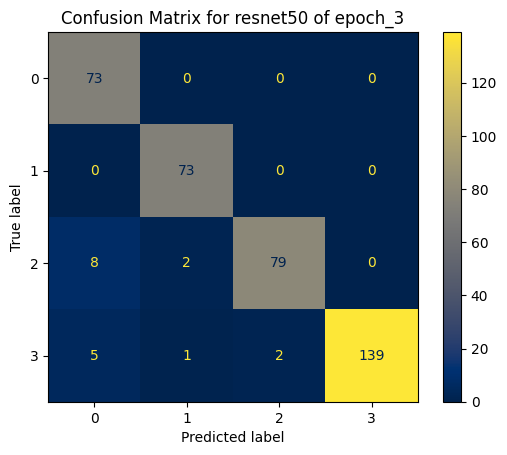

Test set: Average loss: 0.0057, Accuracy: 364/382 (95.29%)

Precision: 0.9578, Recall: 0.9529, F1-score: 0.9533

-------Epoch------- 4
Evaluating model weights: ./models_resnet50/weights/weight_model_epoch_4_resnet50.pth


Test:  42%|████▏     | 5/12 [00:01<00:01,  6.25it/s, accuracy=96.9, loss=0.115]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Test:  75%|███████▌  | 9/12 [00:01<00:00,  6.50it/s, accuracy=95.5, loss=0.15]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


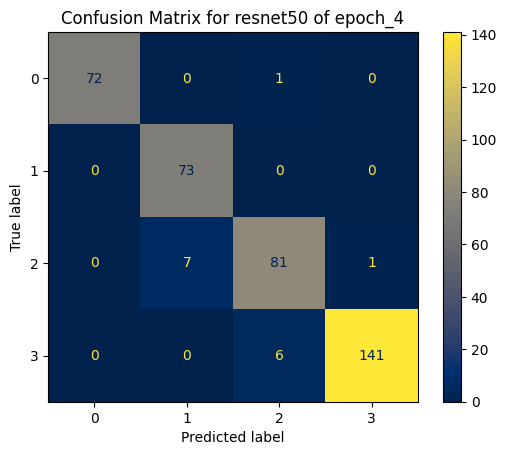

Test set: Average loss: 0.0040, Accuracy: 367/382 (96.07%)

Precision: 0.9620, Recall: 0.9607, F1-score: 0.9609

-------Epoch------- 5
Evaluating model weights: ./models_resnet50/weights/weight_model_epoch_5_resnet50.pth


Test:  42%|████▏     | 5/12 [00:00<00:01,  6.36it/s, accuracy=94.8, loss=0.194]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Test:  75%|███████▌  | 9/12 [00:01<00:00,  7.34it/s, accuracy=95.1, loss=0.175]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


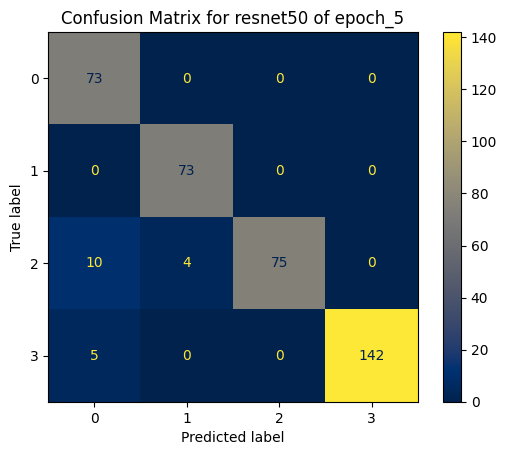

Test set: Average loss: 0.0053, Accuracy: 363/382 (95.03%)

Precision: 0.9575, Recall: 0.9503, F1-score: 0.9506

-------Epoch------- 8
Evaluating model weights: ./models_resnet50/weights/weight_model_epoch_8_resnet50.pth


Test:  42%|████▏     | 5/12 [00:00<00:01,  6.27it/s, accuracy=99, loss=0.0407]  /usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Test:  75%|███████▌  | 9/12 [00:01<00:00,  7.00it/s, accuracy=98.3, loss=0.0439]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Test:  75%|███████▌  | 9/12 [00:01<00:00,  7.00it/s, accuracy=98.4, loss=0.0397]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


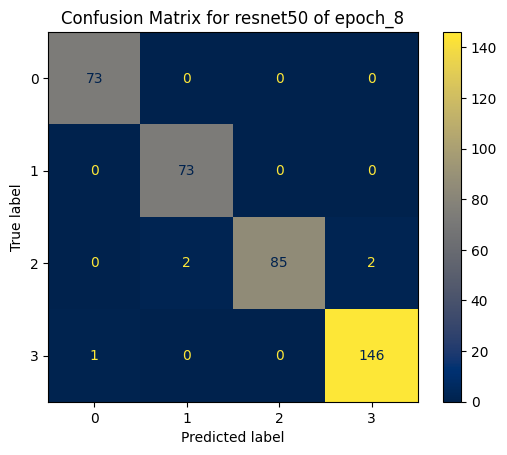

Test set: Average loss: 0.0011, Accuracy: 377/382 (98.69%)

Precision: 0.9871, Recall: 0.9869, F1-score: 0.9868

-------Epoch------- 10
Evaluating model weights: ./models_resnet50/weights/weight_model_epoch_10_resnet50.pth


Test:  42%|████▏     | 5/12 [00:00<00:01,  6.44it/s, accuracy=98.4, loss=0.0356]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Test:  75%|███████▌  | 9/12 [00:01<00:00,  7.18it/s, accuracy=98.6, loss=0.0432]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


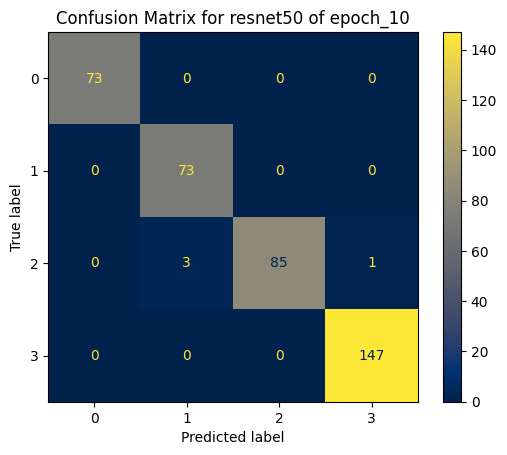

Test set: Average loss: 0.0011, Accuracy: 378/382 (98.95%)

Precision: 0.9899, Recall: 0.9895, F1-score: 0.9895

-------Epoch------- 12
Evaluating model weights: ./models_resnet50/weights/weight_model_epoch_12_resnet50.pth


Test:  58%|█████▊    | 7/12 [00:01<00:01,  4.28it/s, accuracy=98.7, loss=0.0468]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Test:  75%|███████▌  | 9/12 [00:02<00:00,  4.56it/s, accuracy=99, loss=0.0392]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


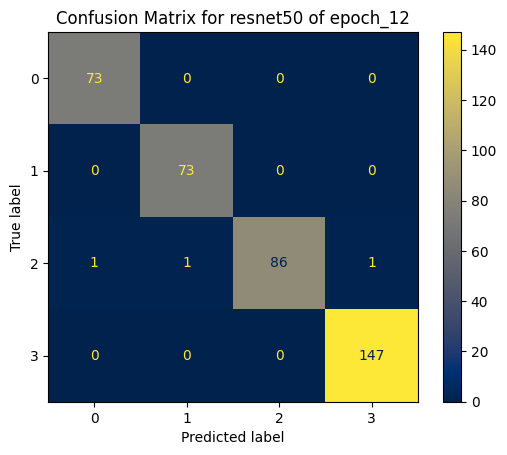

Test set: Average loss: 0.0010, Accuracy: 379/382 (99.21%)

Precision: 0.9922, Recall: 0.9921, F1-score: 0.9921

-------Epoch------- 18
Evaluating model weights: ./models_resnet50/weights/weight_model_epoch_18_resnet50.pth


Test:  42%|████▏     | 5/12 [00:01<00:01,  5.95it/s, accuracy=100, loss=0.00906]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Test:  42%|████▏     | 5/12 [00:01<00:01,  5.95it/s, accuracy=100, loss=0.00812]/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Test:  75%|███████▌  | 9/12 [00:01<00:00,  6.93it/s, accuracy=100, loss=0.00808]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


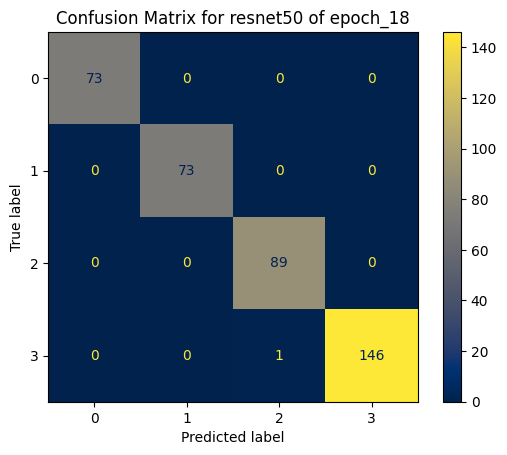

Test set: Average loss: 0.0003, Accuracy: 381/382 (99.74%)

Precision: 0.9974, Recall: 0.9974, F1-score: 0.9974

All the metrics are: 
[{'epoch': 1, 'weight_file': './models_resnet50/weights/weight_model_epoch_1_resnet50.pth', 'test_loss': 0.033602637321693114, 'test_acc': 86.91099476439791, 'precision': 0.9038650433802703, 'recall': 0.8691099476439791, 'f1_score': 0.8717335109902391}, {'epoch': 2, 'weight_file': './models_resnet50/weights/weight_model_epoch_2_resnet50.pth', 'test_loss': 0.008940251670894822, 'test_acc': 92.67015706806282, 'precision': 0.9295115354508663, 'recall': 0.9267015706806283, 'f1_score': 0.9267843484580015}, {'epoch': 3, 'weight_file': './models_resnet50/weights/weight_model_epoch_3_resnet50.pth', 'test_loss': 0.00568010333281849, 'test_acc': 95.28795811518324, 'precision': 0.9578167708573398, 'recall': 0.9528795811518325, 'f1_score': 0.9533178189269575}, {'epoch': 4, 'weight_file': './models_resnet50/weights/weight_model_epoch_4_resnet50.pth', 'test_loss': 0.

In [ ]:
# ------------resnet50

metrics = test_best_model(model, test_loader, params)

print("All the metrics are: ", metrics, sep='\n')